In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

In [3]:
datos = pd.read_csv('/Users/eduardo/Desktop/Personal/BankChurners (1).csv')

In [11]:
datos.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


# Problem Treatment

This situation is basically a binary classification problem, where the target variable is wether a customer is going to be churned or not (not defined timeline). In the data provided, this target is called Attrition_Flag. 

To solve this situation, we can implement several classification models such as Random Forest, Logistic Regression, Gradient Boosting, K nearest neighbors and SVM. We can then assess the effectiveness of each model applied to this data using the Confusion Matrix with it's derived ROC curve and AUC score. I really like using AUC score as measure to decide which model is the best and then the one to use in production. 

However, the data is unbalanced, given that target = 1 is only around 16% of the data, we will need to implement some resmapling technique to avoid this problem and have a better performance in our models. 

This document has the following structure:

1. Data Preparation 

2. Fitting Models

3. Hyperparameter Optimization

4. Decision Making 

5. Conclusions

# Data Preparation

In order to work with this data, we need to transform all categorical variables into binary variables that normally are called dummy variables for each different value in each variable. 

In [1]:
from imblearn.over_sampling import SMOTE

In [9]:
def fun1(x):
    if x == 'Existing Customer':
        resp = 0
    else:
        resp = 1
    return resp

In [10]:
datos['Attrition_Flag'] = datos['Attrition_Flag'].apply(fun1)

In [14]:
X = datos[['Customer_Age', 'Gender',
           'Dependent_count', 'Education_Level', 'Marital_Status',
           'Income_Category', 'Card_Category', 'Months_on_book',
           'Total_Relationship_Count', 'Months_Inactive_12_mon',
           'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
           'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
           'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']]

In [15]:
for col in X.dtypes[X.dtypes == 'object'].index:
    for_dummy = X.pop(col)
    X = pd.concat([X, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [16]:
y = datos['Attrition_Flag']

To solve the unbalanced problem in our data, I choose to use the SMOTE methodology, which is an oversampling method to get a 50-50 sample from the original data.

In [17]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

With this process we have now a 50%-50% distribution in target variable. The dataset is now 17,000 long. 

# Fitting the model

For this section, we will use the classic methodoly in machine learning to train a model. We are going to divide the dataset in training data and test data with a 70%-30% distribution. 

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    train_size = 0.7, test_size=0.3, random_state=2)

### Logistic Regression

In [71]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train);
LR_pred_prob_train = log_reg.predict_proba(X_train)[:,1]
LR_pred_prob_test = log_reg.predict_proba(X_test)[:,1]
LR_auc_train =roc_auc_score(y_train, LR_pred_prob_train)
LR_auc_test =roc_auc_score(y_test, LR_pred_prob_test)
print(LR_auc_train)
print(LR_auc_test)

0.8682510706885058
0.8660479548807619


In [82]:
LRfpr,LRtpr, LRthresholds = roc_curve(y_test,LR_pred_prob_test)

### Random Forest

In [72]:
rf = RandomForestClassifier(n_estimators = 100, max_depth=1)
rf.fit(X_train,y_train);
RF_predict_proba_test = rf.predict_proba(X_test)[:,1]
RF_predict_proba_train = rf.predict_proba(X_train)[:,1]
RF_auc_train =roc_auc_score(y_train, RF_predict_proba_train)
RF_auc_test =roc_auc_score(y_test, RF_predict_proba_test)
print(RF_auc_train)
print(RF_auc_test)

0.9103876947027695
0.9046407075785374


In [83]:
RFfpr,RFtpr,RFthresholds = roc_curve(y_test,RF_predict_proba_test)

### Support Vector Machine

In [73]:
from sklearn.calibration import CalibratedClassifierCV
svmf = CalibratedClassifierCV(base_estimator=svm.LinearSVC(C=17,dual=True), cv=5)
svmf.fit(X_train,y_train);
SVM_predict_proba_test = svmf.predict_proba(X_test)[:,1]
SVM_predict_proba_train = svmf.predict_proba(X_train)[:,1]
SVM_auc_train =roc_auc_score(y_train, SVM_predict_proba_train)
SVM_auc_test =roc_auc_score(y_test, SVM_predict_proba_test)
print(SVM_auc_train)
print(SVM_auc_test)

0.8362767256881827
0.8399540119483405


In [84]:
SVMfpr,SVMtpr,SVMthresholds = roc_curve(y_test,SVM_predict_proba_test)

### KNN

In [74]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=18, metric='minkowski',p=4)
knn.fit(X_train, y_train);
KNN_predict_proba_test = knn.predict_proba(X_test)[:,1]
KNN_predict_proba_train = knn.predict_proba(X_train)[:,1]
KNN_auc_train =roc_auc_score(y_train, KNN_predict_proba_train)
KNN_auc_test =roc_auc_score(y_test, KNN_predict_proba_test)
print(KNN_auc_train)
print(KNN_auc_test)

0.9609339122916902
0.9494524459148916


In [85]:
KNNfpr,KNNtpr,KNNthresholds = roc_curve(y_test,KNN_predict_proba_test)

# Hyperparameter Optimization

I will use the Random Search method from Python to tune a little bit the hyperparameters of Logistic Regression and Light GBM. 

### Optimized Light GBM

In [75]:
from lightgbm import LGBMClassifier

In [76]:
gb_param_gird = {
    'learning_rate': np.arange(0.05, 1.3, 0.05),
    'n_estimators': np.arange(50, 750, 25),
    'max_depth': np.arange(1, 2, 1),
    'num_leaves': np.arange(20, 50, 7)
}
seed = 2
random_search = RandomizedSearchCV(estimator=LGBMClassifier(),
                                   param_distributions=gb_param_gird,
                                   scoring='roc_auc',
                                   random_state=seed,
                                   cv=5,
                                   verbose=1,
                                   n_iter=100,
                                   n_jobs=-1)
models = random_search.fit(X_train, y_train)
lgbm = models.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [77]:
LGBM_predict_proba_test = lgbm.predict_proba(X_test)[:,1]
LGBM_predict_proba_train = lgbm.predict_proba(X_train)[:,1]
LGBM_auc_train =roc_auc_score(y_train, LGBM_predict_proba_train)
LGBM_auc_test =roc_auc_score(y_test, LGBM_predict_proba_test)
print(LGBM_auc_train)
print(LGBM_auc_test)

0.9987435036460598
0.9974449373225127


In [88]:
LGBMfpr_ts,LGBMtpr_ts,LGBMthresholds_ts = roc_curve(y_test,LGBM_predict_proba_test)

### Optimized Logistic Regression

In [78]:
from scipy.stats import loguniform
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)

In [79]:
random_search_logi = RandomizedSearchCV(estimator=LogisticRegression(),
                                   param_distributions=space,
                                   scoring='roc_auc',
                                   random_state=seed,
                                   cv=5,
                                   verbose=1,
                                   n_iter=100,
                                   n_jobs=-1)
models_logi = random_search_logi.fit(X_train, y_train)
logi = models_logi.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [80]:
LOGI_predict_proba_test = logi.predict_proba(X_test)[:,1]
LOGI_predict_proba_train = logi.predict_proba(X_train)[:,1]
LOGI_auc_train =roc_auc_score(y_train, LOGI_predict_proba_train)
LOGI_auc_test =roc_auc_score(y_test, LOGI_predict_proba_test)
print(LOGI_auc_train)
print(LOGI_auc_test)

0.9844509247088322
0.9836263707695907


In [86]:
LOGIfpr,LOGItpr,LOGIthresholds = roc_curve(y_test,LOGI_predict_proba_test)

## Decision Making

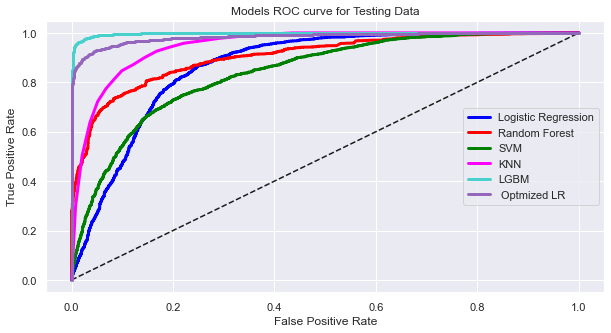

In [90]:
sns.set(rc={'figure.figsize':(10,5)})
plt.plot([0,1],[0,1],'k--')
plt.plot(LRfpr,LRtpr,label = 'Logistic Regression', linewidth=3, color='blue')
plt.plot(RFfpr,RFtpr,label = 'Random Forest', linewidth=3,color='red')
plt.plot(SVMfpr, SVMtpr, label = 'SVM', linewidth=3,color='green')
plt.plot(KNNfpr, KNNtpr, label = 'KNN', linewidth=3,color='magenta')
plt.plot(LGBMfpr_ts, LGBMtpr_ts, label = 'LGBM', linewidth=3,color='mediumturquoise')
plt.plot(LOGIfpr,LOGItpr,label = ' Optmized LR', linewidth=3, color='tab:purple')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Models ROC curve for Testing Data')
plt.legend(loc="center right")
plt.show()

In [92]:
aucs_train = [LR_auc_train,RF_auc_train,SVM_auc_train,KNN_auc_train,LGBM_auc_train,LOGI_auc_train]
aucs_test = [LR_auc_test,RF_auc_test,SVM_auc_test,KNN_auc_test,LGBM_auc_test,LOGI_auc_test]
models = ['LR','RF','SVM','KNN','LGBM','Optim LR']
results = pd.DataFrame()
results['Model'] = models
results['AUC Train'] = aucs_train 
results['AUC Test'] = aucs_test

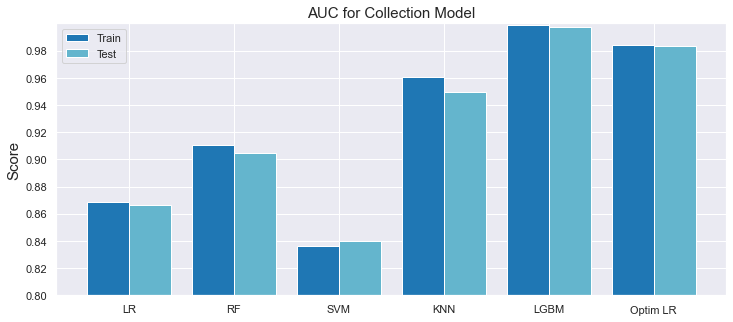

In [107]:
X=results['Model'] 
vals=[results['AUC Train'],results['AUC Test']] 
width=0.8
labels=['Train','Test']
cols=['tab:blue','c']
ylabel='Score'
main='AUC for Collection Model'
n = len(vals)
_X = np.arange(len(X))
for i in range(n):
    plt.bar(_X - width/2. + i/float(n)*width, vals[i], label = labels[i],color = cols[i],
            width=width/float(n), align="edge")   
sns.set(rc={'figure.figsize':(12,5)})

plt.title(main, fontsize =15)
plt.ylabel(ylabel,fontsize =15)
plt.legend(loc="upper left")
plt.xticks(_X, X)
plt.ylim(0.85,1)
plt.yticks(np.arange(0.80,1, step=0.02))
plt.show()

Now that we have fitted all familiar models to our data and measuring their performance all in one metric, we can decide which one is the best. In terms of AUC score, the best model is Light GBM after some hyperparameter tuning (we can get the parameters for this special model to train the model with 100% of data after). 

However, it would depend a lot of the analyst or the head to make the final decision, given some past experience which each model, efficiency and even personal taste. I my case, I would rather use the optimized logistic regression because I like more parametrical models and I understand it quite more. 

### Feature Selection

On the other hand, if we want to go deeper in our model choice, we can check the importance of variables within the LGBM model to see if we can reduce the number of variables that predict customer's attrition. This would be only necessary if we want to be efficient as much as possible in the production model. 

In [100]:
def get_lgbm_varimp(model, train_columns, max_vars=100):
    cv_varimp_df = pd.DataFrame([train_columns, model.feature_importances_]).T
    cv_varimp_df.columns = ['feature_name', 'varimp']
    cv_varimp_df.sort_values(by='varimp', ascending=False, inplace=True)    
    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]
    return cv_varimp_df

In [102]:
importances = get_lgbm_varimp(lgbm,X_resampled.columns)
importances = importances.sort_values('varimp')

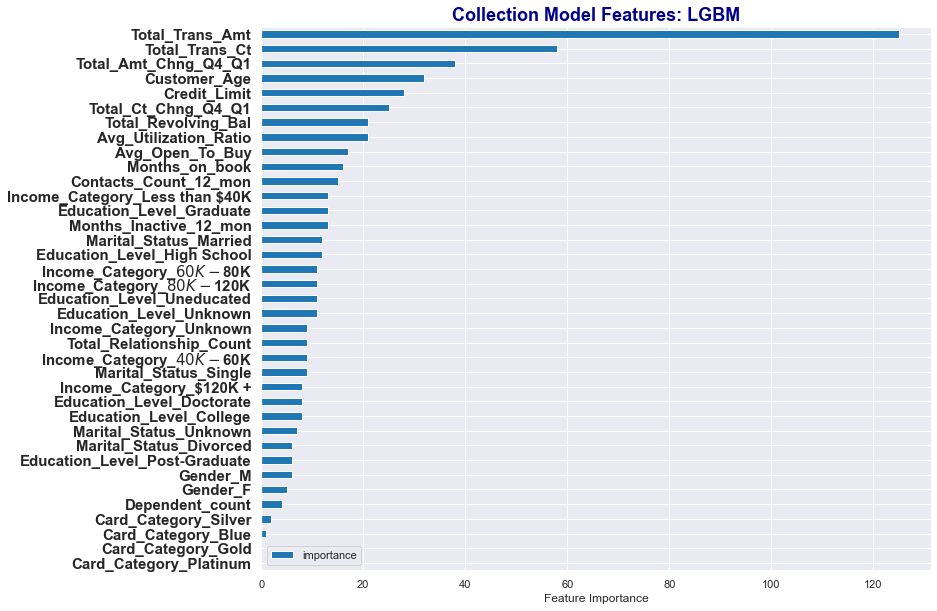

In [105]:
sns.set(rc={'figure.figsize':(12,10)})
importances.plot.barh(x='feature_name',y='varimp', color='tab:blue', label='importance')
plt.xlabel('Feature Importance')
plt.ylabel('')
plt.yticks(weight='bold',fontsize=15)
plt.title('Collection Model Features: LGBM', weight='bold',fontsize=18,color='darkblue')
plt.show()

As we can see, we can get rid of several variables that are not too relevant in our model such as the category of the credit card, marital status and gender, to mention some examples. 